In [1]:
import tensorflow as tf
from configuration import *

print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.9.1


In [2]:
if tf.test.gpu_device_name(): 
    print("Default GPU: {}".format(tf.test.gpu_device_name()))
else:
    print("Not using a GPU - it will take long!!")

Default GPU: /device:GPU:0


In [3]:
print("DATASET_SIZE", DATASET_SIZE)
print("TRAIN_SIZE", TRAIN_SIZE)
print("TEST_SIZE", TEST_SIZE)

tf.random.set_seed(SEED)
print(TRAIN_SIZES)
print(TEST_SIZES)

DATASET_SIZE 294
TRAIN_SIZE 250
TEST_SIZE 44
[250]
[44]


In [4]:
# from dataset_utils import create_paired_s2s_image_loader as create_image_loader
# from dataset_utils import create_augmentation_with_prob, normalize_two as normalize
from dataset_utils import create_paired_s2s_image_loader_indexed_images as create_image_loader

train_dataset = tf.data.Dataset.range(TRAIN_SIZE).shuffle(TRAIN_SIZE)
test_dataset = tf.data.Dataset.range(TEST_SIZE).shuffle(TEST_SIZE)

f2r_train_dataset = train_dataset.map(create_image_loader(2, 3, TRAIN_SIZES, "train"), num_parallel_calls=tf.data.AUTOTUNE)
# # f2r_train_dataset = f2r_train_dataset.map(create_augmentation_with_prob(0.8), num_parallel_calls=tf.data.AUTOTUNE)
# f2r_train_dataset = f2r_train_dataset.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
f2r_train_dataset = f2r_train_dataset.batch(BATCH_SIZE)
f2r_test_dataset = test_dataset.map(create_image_loader(2, 3, TEST_SIZES, "test"), num_parallel_calls=tf.data.AUTOTUNE)
# f2r_test_dataset = f2r_test_dataset.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
f2r_test_dataset = f2r_test_dataset.batch(BATCH_SIZE)

# f2b_train_dataset = train_dataset.map(create_image_loader(2, 3, TRAIN_SIZES, "train", True), num_parallel_calls=tf.data.AUTOTUNE)
# f2b_train_dataset = f2b_train_dataset.batch(BATCH_SIZE)
# f2b_test_dataset = test_dataset.map(create_image_loader(2, 3, TEST_SIZES, "test", False))
# f2b_test_dataset = f2b_test_dataset.batch(BATCH_SIZE)
#
# f2l_train_dataset = train_dataset.map(create_image_loader(2, 1, TRAIN_SIZES, "train", True), num_parallel_calls=tf.data.AUTOTUNE)
# f2l_train_dataset = f2l_train_dataset.batch(BATCH_SIZE)
# f2l_test_dataset = test_dataset.map(create_image_loader(2, 1, TEST_SIZES, "test", False))
# f2l_test_dataset = f2l_test_dataset.batch(BATCH_SIZE)

In [5]:
# ds = f2r_test_dataset
# for i, data in ds.enumerate():
#     print("i", i)

In [6]:
# model.generator.summary()
# from networks import UnetDiscriminator
#
# dsc = UnetDiscriminator()
# dsc.summary(expand_nested=True)

In [7]:
# tf.repeat([[255, 0, 220, 255]], [MAX_PALETTE_SIZE - 56,], axis=0)

In [8]:
# from matplotlib import pyplot as plt
# plt.figure(figsize=(8, 8))
# plt.title("Indexed generated at 0")
# plt.imshow(fake_image)
# plt.axis("off")

In [9]:
# from pix2pix_model import Unet2Generator
# gen = Unet2Generator()
# gen.summary()

In [10]:
from pix2pix_model import Pix2PixModel, Pix2PixIndexedModel

# model = Pix2PixModel(f2r_train_dataset, f2r_test_dataset, "indexed-54", "aiide", "patch", "unet", lambda_histogram=0., lambda_l1=100., lambda_gp=10.)
model = Pix2PixIndexedModel(f2r_train_dataset, f2r_test_dataset, "indexed-54", "aiide", "indexed-patch", "indexed-unet", lambda_l1=0., lambda_segmentation=0.01, lambda_histogram=0.)


Generator: model with 17,540,992 parameters
Discriminator: indexed-patch-disc with 3,649 parameters


In [11]:
# model.discriminator.summary(expand_nested=True)

In [12]:
# STEPS = 40000
# EPOCHS = ceil(TRAIN_SIZE / BATCH_SIZE)
EPOCHS = 160
STEPS = ceil(TRAIN_SIZE / BATCH_SIZE) * EPOCHS
UPDATE_STEPS = STEPS // 40
SHOULD_SAVE_RESULTS = True
SHOULD_GENERATE_ALL_IMAGES_FROM_TEST = True

print(f"Starting training for {EPOCHS} epochs in {STEPS} steps, updating visualization every {UPDATE_STEPS} steps...")

Starting training for 160 epochs in 10080 steps, updating visualization every 252 steps...


Time since start: 04m:09s
Estimated time to finish: 01h:18m:52s
Last 252 steps took: 125.08s



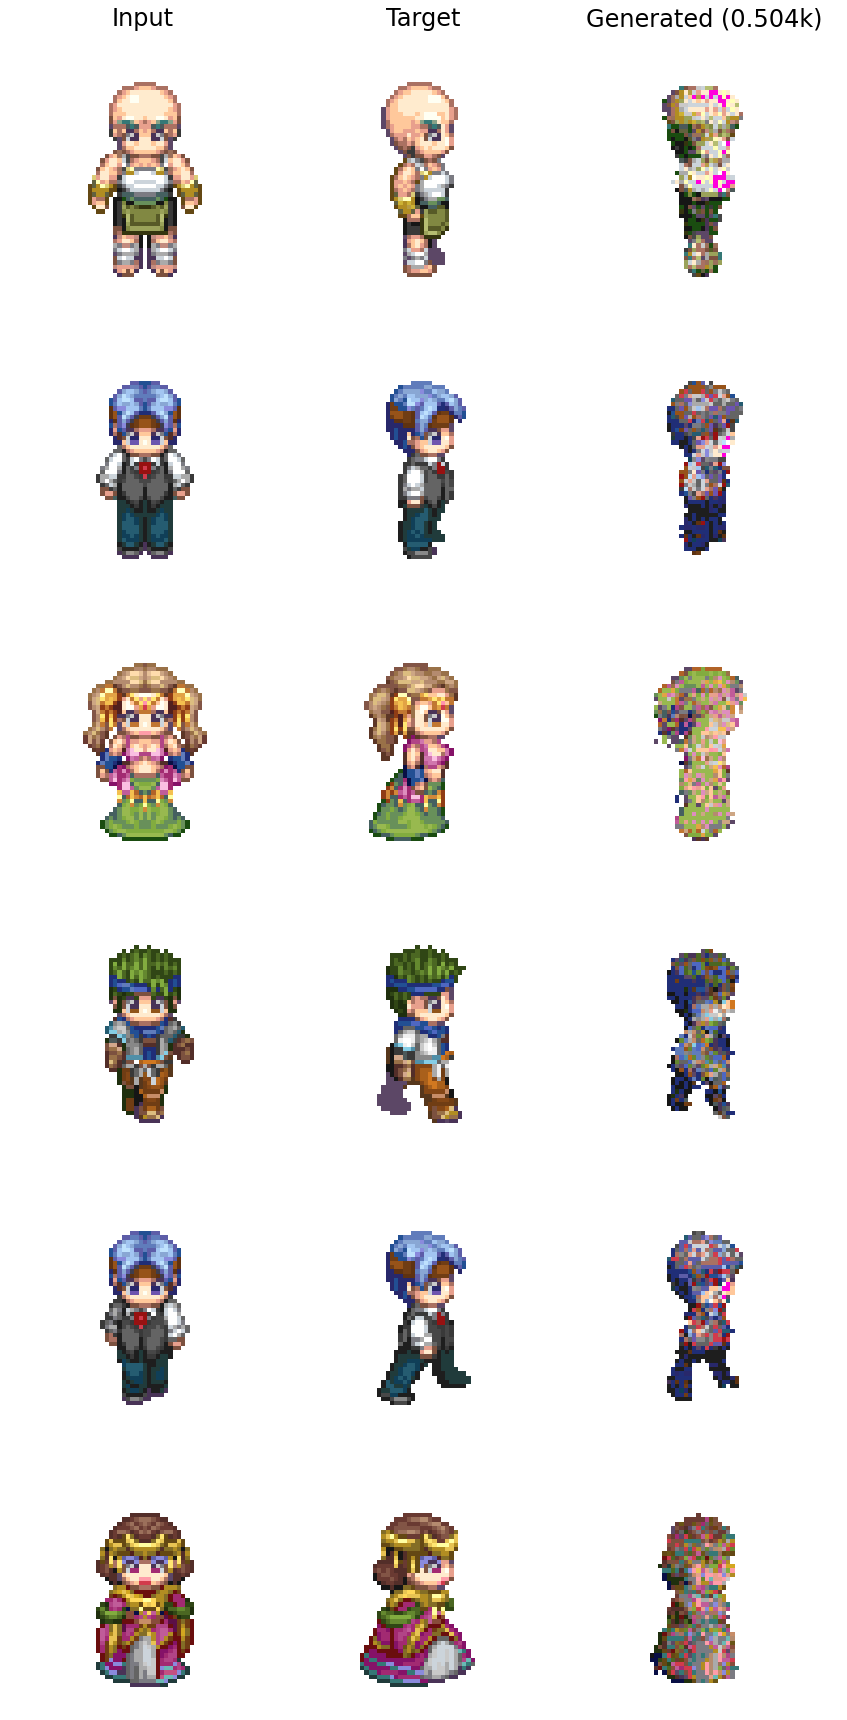

Showing discriminator patches...


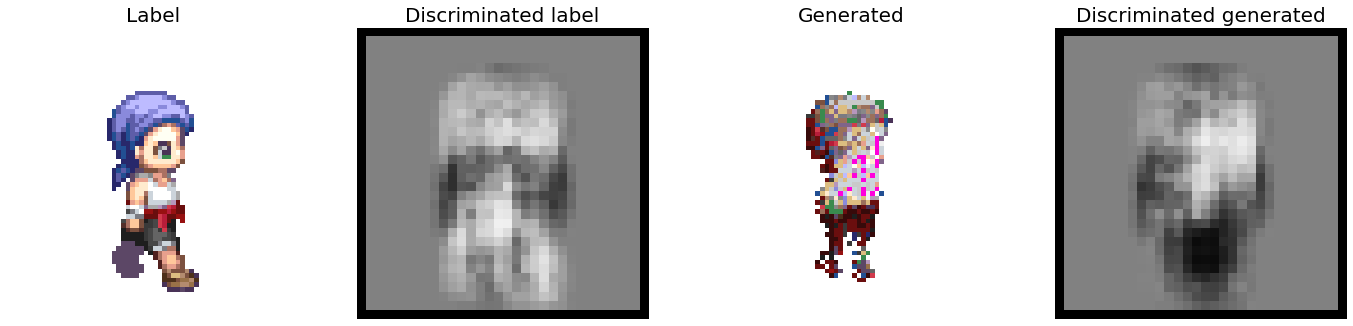

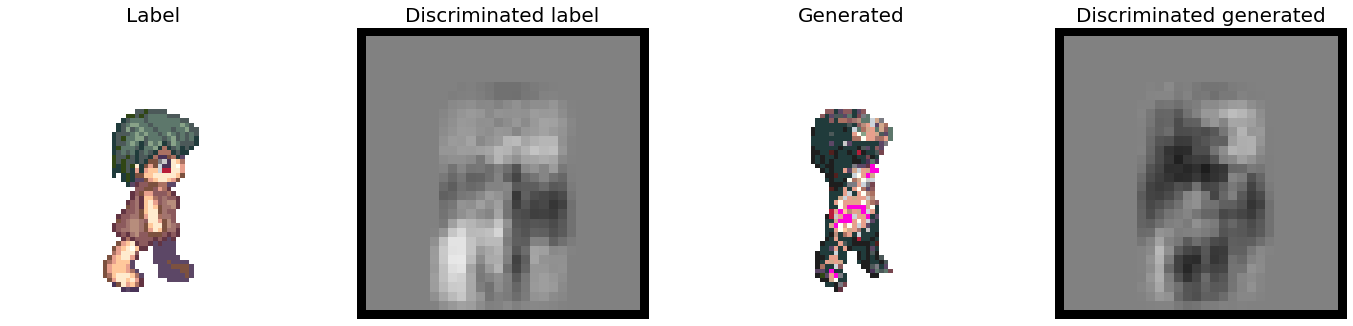

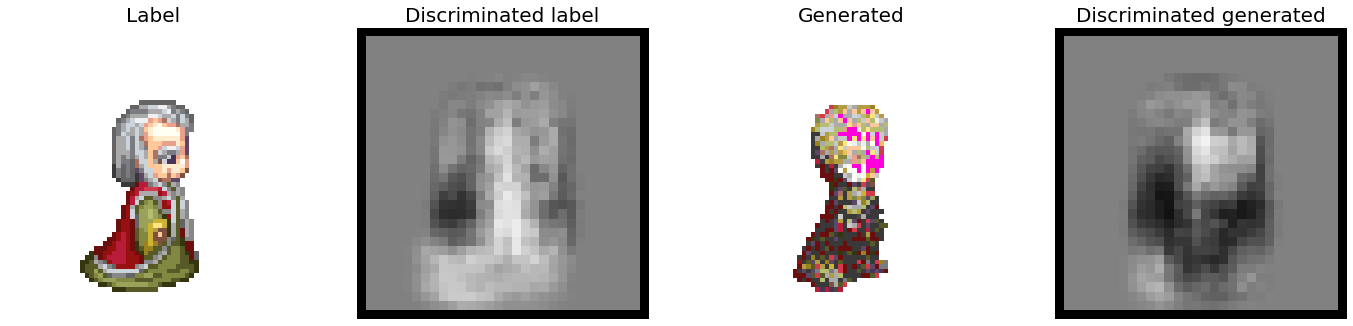

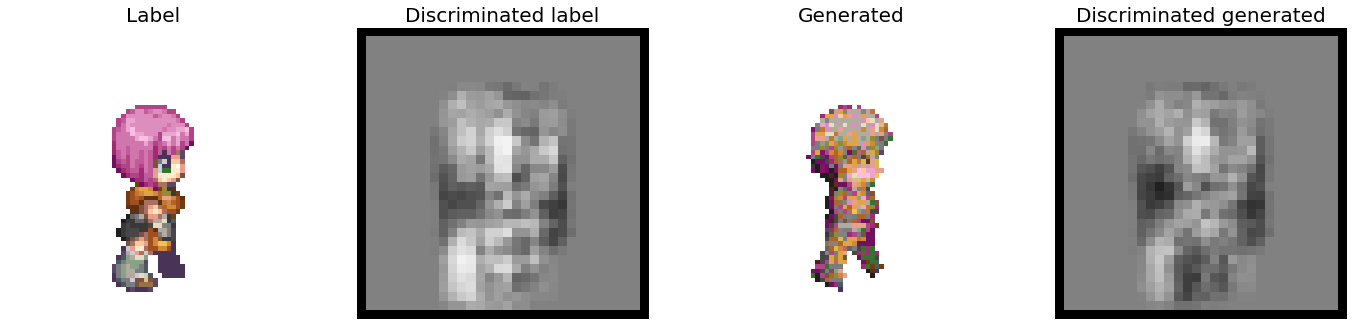

Comparing L1 between generated images from train and test... L1: 8.54288 / 10.13545 (train/test)
2/2 [==============================] - 0s 232ms/step
 FID: 119.172 / 116.740 (train/test)
Step: 0.504k
˯˯˯˯˯˯˯˯˯˯˯˯˯˯˯˯˯˯˯˯˯˯˯˯˯
.....

KeyboardInterrupt: 

In [13]:
model.fit(STEPS, UPDATE_STEPS, callbacks=["show_patches", "fid", "l1"])


In [ ]:
# print("More training...")
# model.save_generator()
# model = Pix2PixModel(f2r_train_dataset, f2r_test_dataset, "front2right", "pix2pix-rpgmakerxp-unetafterunet-unet", "unet", "unet", LAMBDA=100.)
# model.generator = tf.keras.models.load_model(os.sep.join(["models", "py", "generator", "pix2pix-rpgmakerxp-unet-unet", "front2right"]))
# model.fit(STEPS, UPDATE_STEPS, callbacks=["fid", "show_patches"])

def show_classification(dataset_name):
    dataset = model.train_ds if dataset_name == "train" else model.test_ds
    batch = next(iter(dataset.unbatch().batch(44).take(1)))
    source, real = batch#[0], batch[1]
    fake = model.generator(source, training=True)

    _, real_classification = model.discriminator([real, source], training=True)
    _, fake_classification = model.discriminator([fake, source], training=True)

    loss = model.bce

    print(f"classification on {dataset_name} real", real_classification)
    print(f"classification on {dataset_name} fake", fake_classification)

    print(f"generator cls loss on {dataset_name}", loss(tf.ones_like(fake_classification), fake_classification))
    print(f"disc. real cls loss on {dataset_name}", loss(tf.ones_like(real_classification), real_classification))
    print(f"disc. fake cls loss on {dataset_name}", loss(tf.zeros_like(fake_classification), fake_classification))
# show_classification("test")

In [ ]:
if SHOULD_GENERATE_ALL_IMAGES_FROM_TEST:
    # f2r.load_generator()
    model.generate_images_from_dataset()

In [ ]:
if SHOULD_SAVE_RESULTS:
    model.save_generator()
    model.save_discriminator()

In [ ]:
print("Showing discriminator output from TRAIN set...")
model.show_discriminated_images("train", 8)
print("Showing discriminator output from TEST set...")
model.show_discriminated_images("test", 8)

In [ ]:
# model.load_generator()
# model.generate_images_from_dataset(dataset_name="train", num_images=3)
#
# print("Discriminated images from test")
# model.load_discriminator()
# model.show_discriminated_images("train")